# Fitting, Interpolation, and Extrapolation
- Will be useful tools to have in general
- Needed right now for track comparison histos
    - Rather than compare tracks at a given time, compare at a given z value.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import pickle as pkl
from datetime import datetime
from dateutil import parser
import os
import re
from sys import getsizeof

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['axes.axisbelow'] = True

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.io as pio
from plotly import subplots
from plotly import tools
init_notebook_mode(True)

from hallprobecalib import hpc_ext_path
from hallprobecalib.hpcplots import scatter2d,scatter3d,histo

from mu2e import mu2e_ext_path
from mu2e.dataframeprod import DataFrameMaker
from mu2e.mu2eplots import mu2e_plot, mu2e_plot3d
from mu2e.loadtrajectories import LoadTrajectory

In [4]:
import lmfit as lm

In [5]:
data_dir = "/home/ckampa/Coding/Mu2E_Extras/trajectory/run04/"
plot_dir = "/home/ckampa/Coding/Mu2E_Extras/plots/trajectory/run04/fitting/"
run_name = "trajectory_run04_"

## Fitting

### Test with one track
- First try fitting to raw data, then sparse!

In [6]:
df = LoadTrajectory(run=4,event=6,form='raw') # BAD! 6, 7, 9

In [7]:
grouped = df.groupby("B_shift")

In [8]:
df_none = grouped.get_group("NONE")

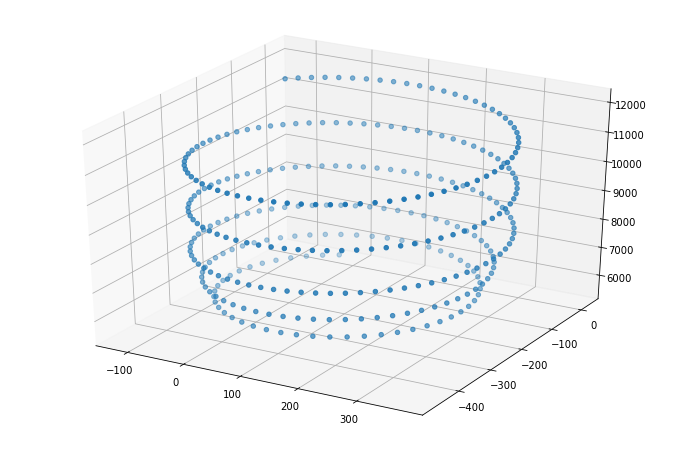

In [9]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df_none[::10].X, df_none.Y[::10], df_none.Z[::10])

In [10]:
X = df_none[(df_none.Z > 8410.) & (df_none.Z < 11660.)].X.reset_index(drop=True)#.values
Y = df_none[(df_none.Z > 8410.) & (df_none.Z < 11660.)].Y.reset_index(drop=True)#.values
Z = df_none[(df_none.Z > 8410.) & (df_none.Z < 11660.)].Z.reset_index(drop=True)#.values
#T = df_none[(df_none.Z > 8410.) & (df_none.Z < 11660.)].time.reset_index(drop=True)#.values
T = pd.Series(np.arange(len(X)))
#T = np.arctan2(Y,X)# * 180 / np.pi
T.name = "T"

In [11]:
scatter3d(X,Y,Z,scale_list=[T], inline=True, show_plot=False)

In [17]:
len(X)

1551

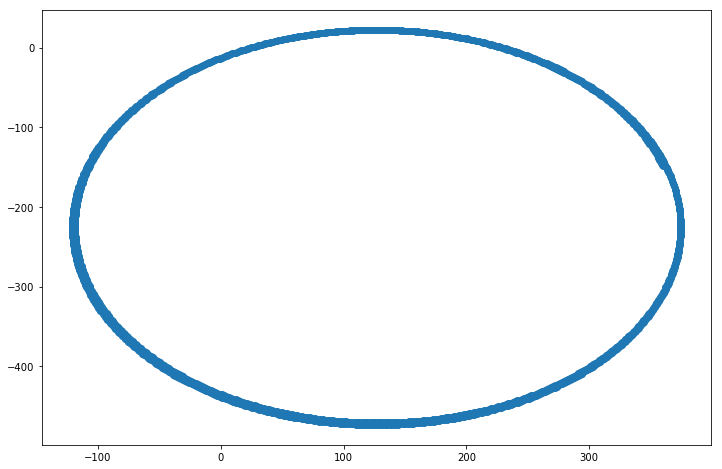

In [12]:
plt.scatter(X,Y)

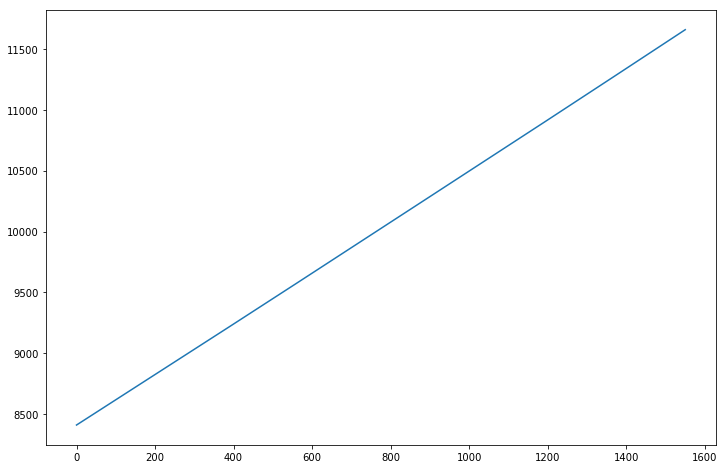

In [13]:
plt.plot(Z)

In [14]:
def circle(t, **parms):
    x = np.zeros_like(t)
    y = np.zeros_like(t)
    R = parms["R"]
    alpha = parms["alpha"]
    x0 = parms["x0"]
    y0 = parms["y0"]
    phi0 = parms["phi0"]
    
    x = R * np.cos(alpha*t + phi0) + x0
    y = R * np.sin(alpha*t + phi0) + y0
    return (x,y)

In [32]:
def circle2(**parms):
    length = parms["length"]
    phi0 = parms["phi0"]
    phi1 = parms["phi1"]
    phi = np.linspace(phi0, phi1, length)
    x = np.zeros_like(phi)
    y = np.zeros_like(phi)
    R = parms["R"]
    x0 = parms["x0"]
    y0 = parms["y0"]
    
    x = R * np.cos(phi) + x0
    y = R * np.sin(phi) + y0
    return (x,y)

In [16]:
import numpy as np

In [21]:
def helix(t, **parms):
    x = np.zeros_like(t)
    y = np.zeros_like(t)
    z = np.zeros_like(t)
    #R, alpha, c = params
    R = parms["R"]
    alpha = parms["alpha"]
    c = parms["c"]
    x0 = parms["x0"]
    y0 = parms["y0"]
    z0 = parms["z0"]
    phi0 = parms["phi0"]
    x = R * np.cos(alpha*t+phi0)# + x0
    y = R * np.sin(alpha*t+phi0)# + y0
    z = c/(2*np.pi) * (alpha*t + phi0)# + z0
    return np.concatenate([x + x0, y + y0, z + z0])

In [22]:
helix(np.linspace(0,10,11), R=1, alpha=1, c=10, x0 = 250, y0 = 150, z0=8410., phi0 = 0)#params={"R":1,"alpha":1,"c":10})

array([ 251.        ,  250.54030231,  249.58385316,  249.0100075 ,
        249.34635638,  250.28366219,  250.96017029,  250.75390225,
        249.85449997,  249.08886974,  249.16092847,  150.        ,
        150.84147098,  150.90929743,  150.14112001,  149.2431975 ,
        149.04107573,  149.7205845 ,  150.6569866 ,  150.98935825,
        150.41211849,  149.45597889, 8410.        , 8411.59154943,
       8413.18309886, 8414.77464829, 8416.36619772, 8417.95774715,
       8419.54929659, 8421.14084602, 8422.73239545, 8424.32394488,
       8425.91549431])

In [33]:
model = lm.Model(circle2)#, independent_vars=['phi'])
params = lm.Parameters()
params.add("R", value=7., max=100., min=0.)
params.add("x0", value=0, vary=True, max=100., min=-100.)#value=(X.max()-X.min())/2)
params.add("y0", value=0, vary=True, max=100., min=-100.)#value=(Y.max()-Y.min())/2)
params.add("phi0", value=0., max=2*np.pi, min=-2*np.pi)
params.add("phi1", value=2*np.pi, max=2*np.pi, min=-2*np.pi)

params.add("length", value=len(x), vary=False)

In [34]:
result = model.fit([X,Y], params=params)
print(result.fit_report())

[[Model]]
    Model(circle2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14
    # data points      = 3102
    # variables        = 5
    chi-square         = 1.1067e+08
    reduced chi-square = 35734.1793
    Akaike info crit   = 32525.9387
    Bayesian info crit = 32556.1377
[[Variables]]
    R:       23.6579322 +/- 45.6149396 (192.81%) (init = 7)
    x0:      99.8646617 +/- 12.1147853 (12.13%) (init = 0)
    y0:     -97.6722755 +/- 25.3745026 (25.98%) (init = 0)
    phi0:    3.55948869 +/- 0.68397650 (19.22%) (init = 0)
    phi1:    5.13232265 +/- 5.01980437 (97.81%) (init = 6.283185)
    length:  1551 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(y0, phi1)   = -0.993
    C(R, phi1)    =  0.991
    C(R, y0)      = -0.974
    C(R, x0)      = -0.958
    C(x0, phi1)   = -0.940
    C(x0, y0)     =  0.922
    C(y0, phi0)   =  0.907
    C(phi0, phi1) = -0.871
    C(R, phi0)    = -0.836
    C(x0, phi0)   =  0.791



In [ ]:
#model = lm.Model(helix, independent_vars=['t'])
model = lm.Model(circle2)
params = lm.Parameters()
params.add("R", value=350., max=700., min=0.)
params.add("alpha", value=.008, max=.5, min=-.5)#1e8)
params.add("c", value=1700.)
params.add("x0", value=X.mean(), vary=True, max=600., min=-600.)#value=(X.max()-X.min())/2)
params.add("y0", value=Y.mean(), vary=True, max=600., min=-600.)#value=(Y.max()-Y.min())/2)
params.add("phi0", value=0., max=np.pi, min=-np.pi)
params.add("z0", value=8410.,vary=True,min=4000.,max=12000.)

samples = np.concatenate([X[::10],Y[::10],Z[::10]])
#samples = np.concatenate([X[::10],Y[::10]])

#result = model.fit(samples, t=np.arange(len(X[::10])), params=params)
result = model.fit(samples, t=T[::10], params=params)

In [23]:
x,y,z = helix(T, R=100, alpha=-.1, c=1708., x0 = 250, y0 = 150, z0=8410., phi0 = 0).reshape((3,-1))

In [24]:
x = pd.Series(x, name="X")

In [25]:
y = pd.Series(y, name="Y")

In [26]:
z = pd.Series(z, name="Z")

In [27]:
scatter3d(x,y,z,inline=True);
#scatter3d([X,x],[Y,y],[Z,z],colors_list=["Viridis","Hot"],inline=True);

In [28]:
#model = lm.Model(helix, independent_vars=['t'])
model = lm.Model(circle, independent_vars=['t'])
params = lm.Parameters()
params.add("R", value=350., max=700., min=0.)
params.add("alpha", value=.008, max=.5, min=-.5)#1e8)
params.add("c", value=1700.)
params.add("x0", value=X.mean(), vary=True, max=600., min=-600.)#value=(X.max()-X.min())/2)
params.add("y0", value=Y.mean(), vary=True, max=600., min=-600.)#value=(Y.max()-Y.min())/2)
params.add("phi0", value=0., max=np.pi, min=-np.pi)
params.add("z0", value=8410.,vary=True,min=4000.,max=12000.)

In [29]:
samples = np.concatenate([X[::10],Y[::10],Z[::10]])
#samples = np.concatenate([X[::10],Y[::10]])

In [30]:
#result = model.fit(samples, t=np.arange(len(X[::10])), params=params)
result = model.fit(samples, t=T[::10], params=params)

ValueError: operands could not be broadcast together with shapes (2,156) (468,) 

In [239]:
#result.params["alpha"]

In [240]:
#for param in result.params:
#    print(param, result.params[param].value)#, param.value)
#result.params["alpha"].value

In [241]:
print(result.fit_report())

[[Model]]
    Model(helix)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 468
    # variables        = 7
    chi-square         = 4654.38978
    reduced chi-square = 10.0962902
    Akaike info crit   = 1089.04177
    Bayesian info crit = 1118.08105
[[Variables]]
    R:      247.086554 +/- 0.25502797 (0.10%) (init = 350)
    alpha:  0.00867319 +/- 2.3385e-06 (0.03%) (init = 0.008)
    c:      1518.21564 +/- 0.57883390 (0.04%) (init = 1700)
    x0:     128.092574 +/- 0.25788010 (0.20%) (init = 139.1234)
    y0:    -225.870967 +/- 0.25796370 (0.11%) (init = -214.6258)
    phi0:   0.35405325 +/- 0.00208555 (0.59%) (init = 0)
    z0:     8318.16640 +/- 0.74284260 (0.01%) (init = 8410)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, z0)       = -0.878
    C(alpha, phi0) = -0.869
    C(alpha, c)    = -0.707
    C(phi0, z0)    = -0.705
    C(alpha, z0)   =  0.621
    C(c, phi0)     =  0.615
    C(x0, phi0)    =  0.153
  

In [228]:
result.chisqr, result.redchi

(4657.046445486936, 10.10205302708663)

In [229]:
results_full = result.eval(t=T).reshape((3,-1))
init_full = result.eval(t=T, params=params).reshape((3,-1))

In [230]:
results_full

array([[ 3.59839396e+02,  3.59089240e+02,  3.58321707e+02, ...,
         2.14440487e+02,  2.12430000e+02,  2.10413168e+02],
       [-1.40391602e+02, -1.38384812e+02, -1.36384605e+02, ...,
         5.54796887e+00,  6.28815788e+00,  7.01088118e+00],
       [ 8.40371378e+03,  8.40580950e+03,  8.40790521e+03, ...,
         1.16478802e+04,  1.16499759e+04,  1.16520717e+04]])

In [231]:
df_true = pd.concat([T,X,Y,Z], axis=1)

In [232]:
df_true.reset_index(drop=True,inplace=True)

In [233]:
df_true["X_fit"] = results_full[0]
df_true["Y_fit"] = results_full[1]
df_true["Z_fit"] = results_full[2]
df_true["X_init"] = init_full[0]
df_true["Y_init"] = init_full[1]
df_true["Z_init"] = init_full[2]

In [235]:
df_true.Z_init

0        9260.000000
1        9262.164507
2        9264.329014
3        9266.493522
4        9268.658029
5        9270.822536
6        9272.987043
7        9275.151551
8        9277.316058
9        9279.480565
10       9281.645072
11       9283.809579
12       9285.974087
13       9288.138594
14       9290.303101
15       9292.467608
16       9294.632116
17       9296.796623
18       9298.961130
19       9301.125637
20       9303.290145
21       9305.454652
22       9307.619159
23       9309.783666
24       9311.948173
25       9314.112681
26       9316.277188
27       9318.441695
28       9320.606202
29       9322.770710
            ...     
1521    12552.215491
1522    12554.379998
1523    12556.544505
1524    12558.709012
1525    12560.873520
1526    12563.038027
1527    12565.202534
1528    12567.367041
1529    12569.531549
1530    12571.696056
1531    12573.860563
1532    12576.025070
1533    12578.189578
1534    12580.354085
1535    12582.518592
1536    12584.683099
1537    12586

In [234]:
scatter3d([df_true.X,df_true.X_fit,df_true.X_init],[df_true.Y,df_true.Y_fit,df_true.Y_init],[df_true.Z,df_true.Z_fit,df_true.Z_init],colors_list=["Viridis","Hot","Greys"],inline=True);
#scatter3d([df_true.X,df_true.X_fit],[df_true.Y,df_true.Y_fit],[df_true.Z,df_true.Z_fit],colors_list=["Viridis","Hot"],inline=True);
#scatter3d([df_true.X_fit],[df_true.Y_fit],[df_true.Z_fit],inline=True);
#scatter3d([df_true.X_init],[df_true.Y_init],[df_true.Z_init],inline=True);

In [220]:
df_true["Res_X"] = df_true["X"] - df_true["X_fit"]
df_true["Res_Y"] = df_true["Y"] - df_true["Y_fit"]
df_true["Res_Z"] = df_true["Z"] - df_true["Z_fit"]

df_true.eval("Res_XYZ = (Res_X**2 + Res_Y**2 + Res_Z**2)**(1/2)", inplace=True)

In [221]:
fig = histo(df_true.Res_XYZ, bins=25, xlabel="Residuals Distance (mm)", autobin=False, inline=True)
fig = histo(df_true.Res_XYZ, bins=25,yscale="log", xlabel="Residuals Distance (mm)", autobin=False, inline=True)

In [56]:
#X.unique
xx = 34.954288

In [64]:
df_test_slice = df_none[(df_none.Z > 8410.) & (df_none.Z < 11660.)][np.isclose(df_true.X,xx, atol=1e-4)]#.query(f"X == {xx}")
df_slice = df_true[np.isclose(df_true.X,xx, atol=1e-4)]

In [66]:
len(df_test_slice)

1

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(df_slice.y.values)

In [458]:
params

Parameters([('R', <Parameter 'R', 150.0, bounds=[-inf:inf]>),
            ('alpha', <Parameter 'alpha', 0.008, bounds=[-inf:inf]>),
            ('c', <Parameter 'c', 1700.0, bounds=[-inf:inf]>),
            ('x0', <Parameter 'x0', 276.2944629318816, bounds=[-inf:inf]>),
            ('y0', <Parameter 'y0', 73.06930096104377, bounds=[-inf:inf]>),
            ('phi0', <Parameter 'phi0', 3.141592653589793, bounds=[-inf:inf]>),
            ('z0', <Parameter 'z0', 8410.0, bounds=[-inf:inf]>)])

## Fit All Tracks

In [336]:
def helix(t, **parms):
    x = np.zeros_like(t)
    y = np.zeros_like(t)
    z = np.zeros_like(t)
    #R, alpha, c = params
    R = parms["R"]
    alpha = parms["alpha"]
    c = parms["c"]
    x0 = parms["x0"]
    y0 = parms["y0"]
    z0 = parms["z0"]
    phi0 = parms["phi0"]
    helicity = parms["helicity"]
    if helicity == 0.05:
        hel = 1
    else:
        hel = -1
    x = R * np.cos(hel*alpha*t+phi0)# + x0
    y = R * np.sin(hel*alpha*t+phi0)# + y0
    z = c/(2*np.pi) * (alpha*t + phi0)# + z0
    return np.concatenate([x + x0, y + y0, z + z0])

In [269]:
model = lm.Model(helix, independent_vars=['t'])
params = lm.Parameters()
params.add("R", value=150., max=500., min=-500.)
params.add("alpha", value=.008)#1e8)
params.add("c", value=1700.)
params.add("x0", value=X.mean(), vary=True)#value=(X.max()-X.min())/2)
params.add("y0", value=Y.mean(), vary=True)#value=(Y.max()-Y.min())/2)
params.add("phi0", value=np.pi)
params.add("z0", value=8410.,vary=True)
params.add("helicity", value=True,vary=True)

In [337]:
param_dict = {k: [] for k in params}

In [338]:
param_dict

{'R': [],
 'alpha': [],
 'c': [],
 'x0': [],
 'y0': [],
 'phi0': [],
 'z0': [],
 'helicity': []}

In [339]:
events = []
shifts = []
red_chis = []

In [340]:
for event in range(10):
    stride = 1
    df = LoadTrajectory(run=4,event=event,form='raw')
    if df.Z.max() < 8410.:
        continue
    #df = df[::stride]
    grouped = df.groupby("B_shift")
    print(f"Event: {event}")
    
    for shift in ["NONE","X","Y","Z"]:
        events.append(event)
        shifts.append(shift)
        df_ = grouped.get_group(shift)
        df_ = df_[::stride]
        X = df_[(df_.Z > 8410.) & (df_.Z < 11660.)].X.reset_index(drop=True)#.values
        Y = df_[(df_.Z > 8410.) & (df_.Z < 11660.)].Y.reset_index(drop=True)#.values
        Z = df_[(df_.Z > 8410.) & (df_.Z < 11660.)].Z.reset_index(drop=True)#.values
        T = pd.Series(np.arange(len(X)))
        T.name = "T"
        samples = np.concatenate([X,Y,Z])
        
        #model = lm.Model(helix, independent_vars=['t'])
        """
        params = lm.Parameters()
        params.add("R", value=100.)
        params.add("alpha", value=.08)#1e8)
        params.add("c", value=1000.)
        params.add("x0", value=X.mean(), vary=True)#value=(X.max()-X.min())/2)
        params.add("y0", value=Y.mean(), vary=True)#value=(Y.max()-Y.min())/2)
        params.add("phi0", value=np.pi)
        params.add("z0", value=8410.,vary=True)
        """        
        params = lm.Parameters()
        params.add("R", value=350., max=700., min=0.)
        params.add("alpha", value=.008, max=.5, min=0.)#1e8)
        params.add("c", value=1700.)
        params.add("x0", value=X.mean(), vary=True, max=600., min=-600.)#value=(X.max()-X.min())/2)
        params.add("y0", value=Y.mean(), vary=True, max=600., min=-600.)#value=(Y.max()-Y.min())/2)
        params.add("phi0", value=0., max=np.pi, min=-np.pi)
        params.add("z0", value=8410.,vary=True,min=4000.,max=12000.)
        #params.add("dummy", value = 1e-10, max=1e-10, min=-1e-10)#, brute_step=0.02)
        #params.add("helicity", expr="True if dummy > 0 else False")#value=True,vary=True)
        params.add("helicity", value=0.05,vary=True, min=0., max=0.1)
        
        result = model.fit(samples, t=T, params=params)#, method="least_squares")
        
        #print(result.fit_report())
        
        red_chis.append(result.redchi)
        for param in result.params:
            param_dict[param].append(result.params[param].value)

#df_none = grouped.get_group("NONE")

Event: 0
Event: 1
Event: 2
Event: 3
Event: 5
Event: 6
Event: 7
Event: 8
Event: 9


In [341]:
param_dict

{'R': [7.712885885524656e-10,
  3.912150658980096e-07,
  1.0957901253050295e-11,
  7.173150962103136e-10,
  1.03711483845359e-09,
  2.842059920737938e-10,
  5.092315458199437e-10,
  4.4204639948475233e-10,
  149.14388408719665,
  149.276512170075,
  150.04567300720134,
  148.49219980460467,
  3.016385052845294e-06,
  3.7902205374251707e-06,
  4.312779688930846e-06,
  2.8920620287475884e-06,
  121.49681187245903,
  122.02135326354318,
  121.6906070944855,
  121.1958867290791,
  247.0954686316607,
  246.4056145412979,
  246.6373987529888,
  245.3286256376722,
  277.1607543724149,
  276.716686210179,
  278.0498303398907,
  281.2703420214604,
  256.64794436845307,
  256.59836291407487,
  258.78048507940514,
  262.1223807091543,
  284.35929373647514,
  283.1440890492762,
  284.8223138397952,
  283.5351764076333],
 'alpha': [0.00767027967514719,
  0.0076717937628379695,
  0.007668643391701396,
  0.007677463015223596,
  0.006789960089361863,
  0.0067762706627878255,
  0.00675005056240055,
  0

In [342]:
len(red_chis)

36

In [343]:
red_chis

[14282.281832303488,
 14422.39454163472,
 14300.614536941675,
 14241.252118902092,
 959.1158869318785,
 975.2012476439552,
 993.2360602756199,
 951.105932450384,
 0.9574881199756101,
 1.070335988847239,
 0.9566017391841961,
 0.95921487965124,
 5586.13982849062,
 5670.624756201857,
 5577.270004723842,
 5529.180571548571,
 4.363150684843679,
 4.802893897301854,
 4.228189073732409,
 4.415002682825452,
 9.795845122163472,
 9.917362788673545,
 9.749934641328599,
 9.759108983776185,
 30.227441168666555,
 30.82789260169415,
 30.41192676607481,
 32.629268519772424,
 13.94060932041276,
 14.313634477563852,
 14.570558315340515,
 16.597421744714882,
 22.876621885494586,
 21.9614525171706,
 23.09103852103903,
 22.682466354150126]

In [87]:
len(events)

36

In [57]:
events

[0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 4,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 4,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9]

## Testing Param Init Conditions

In [258]:
scatter3d(X,Y,Z,inline=True)